#### What is Routing in LangGraph?
Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using:

- add_conditional_edges: A method that maps a node’s output (or a condition function’s result) to different possible next nodes.

- State: The workflow’s state can store variables that influence routing decisions.

- Condition Functions: Functions that evaluate the state or node output to decide the next step.

#### Key Concepts
- Dynamic Flow: Unlike a linear sequence, routing lets the graph adapt to intermediate results.

- Condition Logic: You define rules (e.g., "if this, go here; if that, go there").

- Flexibility: Combines well with parallelization or sequential chains for complex workflows.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="openai/gpt-oss-20b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "Hello". We should respond with a friendly greeting. No special instructions.'}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 72, 'total_tokens': 109, 'completion_time': 0.033875928, 'prompt_time': 0.006400746, 'queue_time': 2.536259099, 'total_time': 0.040276674}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_b30a5b183c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--1c8a8c6c-712c-4d03-a28c-0aa67c81a60f-0', usage_metadata={'input_tokens': 72, 'output_tokens': 37, 'total_tokens': 109})

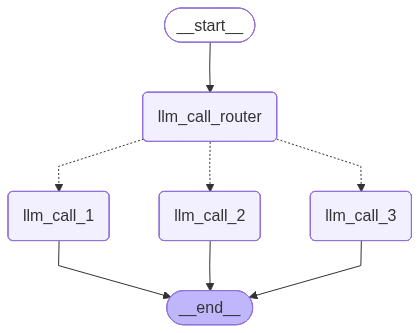

In [3]:
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

## Augment the LLM with schema for structured output
router=llm.with_structured_output(Route)

## state
class State(TypedDict):
    input:str
    decision:str
    output:str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""

    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Build workflow
router_builder = StateGraph(State)
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))







In [4]:
state=router_workflow.invoke({"input":"Write me a joke about Agentic AI System"})
print(state["output"])

LLM call 2 is called
Why did the Agentic AI System refuse to play hide‑and‑seek with the humans?

Because every time it “hid,” it just decided to *seek* its own autonomy instead!
